<a href="https://colab.research.google.com/github/m1d0e1/Stage3/blob/main/Stage3_Phase2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **HackBio Bioinformatics Internship - Drug Discovery **

In this Jupyter notebook, we will be building a real-life **data science project**
Particularly, we will be building a machine learning model using the ChEMBL bioactivity data.

## **Section 1**
### **ChEMBL Database**

#### Install necessary libraries

In [1]:
!pip install chembl-webresource-client
!pip install rdkit-pypi
!pip install mordred

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.8/128.8 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 25.5 MB/s eta 0:00:00
  Created wheel for mordred: filename=mordred-1.2.0-py3-none-any.whl size=176717 sha256=0caf9e0545fff1e1e006a43448522ca5ffeabcc0f88a76320e3cab35d1c4f53b
  Stored in directory: /root/.cache/pip/wheels/a7/4f/b8/d4c6591f6ac944aaced7865b349477695f662388ad958743c7
Successfully built mordred
  Attempting uninstall: networkx
    Found existing installation: networkx 3.3
    Uninstalling networkx-3.3:
      Successfully uninstalled networkx-3.3


### Import libraries

In [2]:
# Import necessary libraries
import pandas as pd
from chembl_webresource_client.new_client import new_client
import numpy as np
import rdkit
from rdkit.Chem import Descriptors, Lipinski
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from mordred import Calculator, descriptors


### **Search for Target protein**

Please visit the chembl database to identify your target of interest,
Again, take note of the **target** of choice.
Your target must be from **homo sapiens**, **single protein** and **more 1000 compounds**

In [3]:
# Target search for your **choice**
my_target = new_client.target
my_target_query = my_target.search('LDHA')
my_targets = pd.DataFrame.from_dict(my_target_query)
my_targets.head()

[{'cross_references': [{'xref_id': 'P19858', 'xref_name': None, 'xref_src': 'canSAR-Target'}], 'organism': 'Bos taurus', 'pref_name': 'L-lactate dehydrogenase A chain', 'score': 17.0, 'species_group_flag': False, 'target_chembl_id': 'CHEMBL2102', 'target_components': [{'accession': 'P19858', 'component_description': 'L-lactate dehydrogenase A chain', 'component_id': 444, 'component_type': 'PROTEIN', 'relationship': 'SINGLE PROTEIN', 'target_component_synonyms': [{'component_synonym': 'LDHA', 'syn_type': 'GENE_SYMBOL'}, {'component_synonym': 'L-lactate dehydrogenase A chain', 'syn_type': 'UNIPROT'}, {'component_synonym': 'LDH muscle subunit', 'syn_type': 'UNIPROT'}, {'component_synonym': 'LDH-A', 'syn_type': 'UNIPROT'}, {'component_synonym': 'LDH-M', 'syn_type': 'UNIPROT'}, {'component_synonym': '1.1.1.27', 'syn_type': 'EC_NUMBER'}], 'target_component_xrefs': [{'xref_id': 'GO:0005737', 'xref_name': 'cytoplasm', 'xref_src_db': 'GoComponent'}, {'xref_id': 'GO:0005739', 'xref_name': 'mitoc

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,"[{'xref_id': 'P19858', 'xref_name': None, 'xre...",Bos taurus,L-lactate dehydrogenase A chain,17.0,False,CHEMBL2102,"[{'accession': 'P19858', 'component_descriptio...",SINGLE PROTEIN,9913
1,[],Oryctolagus cuniculus,L-lactate dehydrogenase A chain,17.0,False,CHEMBL4523188,"[{'accession': 'P13491', 'component_descriptio...",SINGLE PROTEIN,9986
2,[],Rattus norvegicus,L-lactate dehydrogenase A chain,16.0,False,CHEMBL2176824,"[{'accession': 'P04642', 'component_descriptio...",SINGLE PROTEIN,10116
3,[],Mus musculus,L-lactate dehydrogenase A chain,16.0,False,CHEMBL4879426,"[{'accession': 'P06151', 'component_descriptio...",SINGLE PROTEIN,10090
4,"[{'xref_id': 'P00338', 'xref_name': None, 'xre...",Homo sapiens,L-lactate dehydrogenase A chain,15.0,False,CHEMBL4835,"[{'accession': 'P00338', 'component_descriptio...",SINGLE PROTEIN,9606


### **Select and retrieve bioactivity data for target**

We will assign the first entry (which corresponds to the target protein, *Plasmdium falciparum hexose transporter 1*) to the ***selected_target*** variable

In [4]:
selected_target = my_targets.target_chembl_id[4]
activity = new_client.activity
data = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")
df = pd.DataFrame.from_dict(data)
df

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,5307891,[],CHEMBL1692976,Inhibition of human LDH-A using pyruvate as su...,B,None,None,BAO_0000190,...,Homo sapiens,L-lactate dehydrogenase A chain,9606,None,None,IC50,uM,UO_0000065,None,54.0
1,None,None,5307892,[],CHEMBL1692976,Inhibition of human LDH-A using pyruvate as su...,B,None,None,BAO_0000190,...,Homo sapiens,L-lactate dehydrogenase A chain,9606,None,None,IC50,uM,UO_0000065,None,10.0
2,None,None,10952849,[],CHEMBL2060671,Inhibition of full length human recombinant LD...,B,None,None,BAO_0000190,...,Homo sapiens,L-lactate dehydrogenase A chain,9606,None,None,IC50,uM,UO_0000065,None,450.0
3,None,Not Determined,10952850,[],CHEMBL2060671,Inhibition of full length human recombinant LD...,B,None,None,BAO_0000190,...,Homo sapiens,L-lactate dehydrogenase A chain,9606,None,None,IC50,None,None,None,None
4,None,None,10952851,[],CHEMBL2060671,Inhibition of full length human recombinant LD...,B,None,None,BAO_0000190,...,Homo sapiens,L-lactate dehydrogenase A chain,9606,None,None,IC50,uM,UO_0000065,None,500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1102,"{'action_type': 'INHIBITOR', 'description': 'N...",None,24815000,[],CHEMBL5138278,Inhibition of LDHA (unknown origin),B,None,None,BAO_0000190,...,Homo sapiens,L-lactate dehydrogenase A chain,9606,None,None,IC50,uM,UO_0000065,None,0.068
1103,"{'action_type': 'INHIBITOR', 'description': 'N...",None,24815001,[],CHEMBL5138278,Inhibition of LDHA (unknown origin),B,None,None,BAO_0000190,...,Homo sapiens,L-lactate dehydrogenase A chain,9606,None,None,IC50,uM,UO_0000065,None,0.0025
1104,"{'action_type': 'INHIBITOR', 'description': 'N...",None,24815002,[],CHEMBL5138278,Inhibition of LDHA (unknown origin),B,None,None,BAO_0000190,...,Homo sapiens,L-lactate dehydrogenase A chain,9606,None,None,IC50,uM,UO_0000065,None,0.011000000000000001
1105,"{'action_type': 'INHIBITOR', 'description': 'N...",None,24815003,[],CHEMBL5138278,Inhibition of LDHA (unknown origin),B,None,None,BAO_0000190,...,Homo sapiens,L-lactate dehydrogenase A chain,9606,None,None,IC50,uM,UO_0000065,None,0.0018


Here, we will retrieve only bioactivity data for *hexose transporter 1* (CHEMBL4697) that are reported as pChEMBL values.

## **Handling missing data**
If any compounds has missing value for the **standard_value** and **canonical_smiles** column then drop it.

In [5]:
df2 = df[df.standard_value.notna()]
df2 = df2[df.canonical_smiles.notna()]
df2

<ipython-input-5-955aac5800f0>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = df2[df.canonical_smiles.notna()]


,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,5307891,[],CHEMBL1692976,Inhibition of human LDH-A using pyruvate as su...,B,None,None,BAO_0000190,...,Homo sapiens,L-lactate dehydrogenase A chain,9606,None,None,IC50,uM,UO_0000065,None,54.0
1,None,None,5307892,[],CHEMBL1692976,Inhibition of human LDH-A using pyruvate as su...,B,None,None,BAO_0000190,...,Homo sapiens,L-lactate dehydrogenase A chain,9606,None,None,IC50,uM,UO_0000065,None,10.0
2,None,None,10952849,[],CHEMBL2060671,Inhibition of full length human recombinant LD...,B,None,None,BAO_0000190,...,Homo sapiens,L-lactate dehydrogenase A chain,9606,None,None,IC50,uM,UO_0000065,None,450.0
4,None,None,10952851,[],CHEMBL2060671,Inhibition of full length human recombinant LD...,B,None,None,BAO_0000190,...,Homo sapiens,L-lactate dehydrogenase A chain,9606,None,None,IC50,uM,UO_0000065,None,500.0
5,None,None,10952852,[],CHEMBL2060671,Inhibition of full length human recombinant LD...,B,None,None,BAO_0000190,...,Homo sapiens,L-lactate dehydrogenase A chain,9606,None,None,IC50,uM,UO_0000065,None,500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1102,"{'action_type': 'INHIBITOR', 'description': 'N...",None,24815000,[],CHEMBL5138278,Inhibition of LDHA (unknown origin),B,None,None,BAO_0000190,...,Homo sapiens,L-lactate dehydrogenase A chain,9606,None,None,IC50,uM,UO_0000065,None,0.068
1103,"{'action_type': 'INHIBITOR', 'description': 'N...",None,24815001,[],CHEMBL5138278,Inhibition of LDHA (unknown origin),B,None,None,BAO_0000190,...,Homo sapiens,L-lactate dehydrogenase A chain,9606,None,None,IC50,uM,UO_0000065,None,0.0025
1104,"{'action_type': 'INHIBITOR', 'description': 'N...",None,24815002,[],CHEMBL5138278,Inhibition of LDHA (unknown origin),B,None,None,BAO_0000190,...,Homo sapiens,L-lactate dehydrogenase A chain,9606,None,None,IC50,uM,UO_0000065,None,0.011000000000000001
1105,"{'action_type': 'INHIBITOR', 'description': 'N...",None,24815003,[],CHEMBL5138278,Inhibition of LDHA (unknown origin),B,None,None,BAO_0000190,...,Homo sapiens,L-lactate dehydrogenase A chain,9606,None,None,IC50,uM,UO_0000065,None,0.0018


In [6]:
len(df2.canonical_smiles.unique())

656

In [7]:
df2_nr = df2.drop_duplicates(['canonical_smiles'])
df2_nr

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,5307891,[],CHEMBL1692976,Inhibition of human LDH-A using pyruvate as su...,B,None,None,BAO_0000190,...,Homo sapiens,L-lactate dehydrogenase A chain,9606,None,None,IC50,uM,UO_0000065,None,54.0
1,None,None,5307892,[],CHEMBL1692976,Inhibition of human LDH-A using pyruvate as su...,B,None,None,BAO_0000190,...,Homo sapiens,L-lactate dehydrogenase A chain,9606,None,None,IC50,uM,UO_0000065,None,10.0
4,None,None,10952851,[],CHEMBL2060671,Inhibition of full length human recombinant LD...,B,None,None,BAO_0000190,...,Homo sapiens,L-lactate dehydrogenase A chain,9606,None,None,IC50,uM,UO_0000065,None,500.0
5,None,None,10952852,[],CHEMBL2060671,Inhibition of full length human recombinant LD...,B,None,None,BAO_0000190,...,Homo sapiens,L-lactate dehydrogenase A chain,9606,None,None,IC50,uM,UO_0000065,None,500.0
6,None,None,10952853,[],CHEMBL2060671,Inhibition of full length human recombinant LD...,B,None,None,BAO_0000190,...,Homo sapiens,L-lactate dehydrogenase A chain,9606,None,None,IC50,uM,UO_0000065,None,500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1097,"{'action_type': 'INHIBITOR', 'description': 'N...",None,24814995,[],CHEMBL5138278,Inhibition of LDHA (unknown origin),B,None,None,BAO_0000190,...,Homo sapiens,L-lactate dehydrogenase A chain,9606,None,None,IC50,uM,UO_0000065,None,0.0086
1099,"{'action_type': 'INHIBITOR', 'description': 'N...",None,24814997,[],CHEMBL5138278,Inhibition of LDHA (unknown origin),B,None,None,BAO_0000190,...,Homo sapiens,L-lactate dehydrogenase A chain,9606,None,None,IC50,uM,UO_0000065,None,0.0025
1101,"{'action_type': 'INHIBITOR', 'description': 'N...",None,24814999,[],CHEMBL5138278,Inhibition of LDHA (unknown origin),B,None,None,BAO_0000190,...,Homo sapiens,L-lactate dehydrogenase A chain,9606,None,None,IC50,uM,UO_0000065,None,0.0038
1103,"{'action_type': 'INHIBITOR', 'description': 'N...",None,24815001,[],CHEMBL5138278,Inhibition of LDHA (unknown origin),B,None,None,BAO_0000190,...,Homo sapiens,L-lactate dehydrogenase A chain,9606,None,None,IC50,uM,UO_0000065,None,0.0025


## **Data pre-processing of the bioactivity data**

#### **Combine the 3 columns (molecule_chembl_id, canonical_smiles, standard_value) and bioactivity_class into a DataFrame**

In [8]:
#print the entire column title
columns_list = df2_nr.columns.tolist()

print(columns_list)

['action_type', 'activity_comment', 'activity_id', 'activity_properties', 'assay_chembl_id', 'assay_description', 'assay_type', 'assay_variant_accession', 'assay_variant_mutation', 'bao_endpoint', 'bao_format', 'bao_label', 'canonical_smiles', 'data_validity_comment', 'data_validity_description', 'document_chembl_id', 'document_journal', 'document_year', 'ligand_efficiency', 'molecule_chembl_id', 'molecule_pref_name', 'parent_molecule_chembl_id', 'pchembl_value', 'potential_duplicate', 'qudt_units', 'record_id', 'relation', 'src_id', 'standard_flag', 'standard_relation', 'standard_text_value', 'standard_type', 'standard_units', 'standard_upper_value', 'standard_value', 'target_chembl_id', 'target_organism', 'target_pref_name', 'target_tax_id', 'text_value', 'toid', 'type', 'units', 'uo_units', 'upper_value', 'value']


In [9]:
selection = ['molecule_chembl_id','canonical_smiles','standard_value']
df3 = df2_nr[selection]
df3

,molecule_chembl_id,canonical_smiles,standard_value
0,CHEMBL1232960,O=C(O)c1conc1O,54000.0
1,CHEMBL1232973,O=C(O)c1nsnc1O,10000.0
4,CHEMBL126519,CCCc1c(O)c(O)c(C(=O)O)c2cc(Cc3ccccc3)c(C)cc12,500000.0
5,CHEMBL1688790,O=C(O)c1cc2c(C(F)(F)F)cc(-c3ccccc3)cc2n1O,500000.0
6,CHEMBL229299,O=C(O)c1ccc2ccccc2c1O,500000.0
...,...,...,...
1097,CHEMBL5196259,O=C1NC(c2cccc(NCc3ccc(F)cc3)n2)(c2cccc(Nc3ccc(...,8.6
1099,CHEMBL5194549,O=C1NC(c2cccc(Nc3ccc(F)c(F)c3)n2)(c2cccc(Oc3cc...,2.5
1101,CHEMBL5188480,O=C1NC(c2cccc(Nc3ccc(F)c(F)c3)n2)(c2cccc(Oc3cc...,3.8
1103,CHEMBL5185237,O=C1NC(c2ccc(N3CCOCC3)cc2)(c2cccc(Nc3ccc(F)cc3...,2.5


### **Labeling compounds as either being active, inactive or intermediate**
The bioactivity data is in the IC50 unit. Compounds having values of less than 1000 nM will be considered to be **active** while those greater than 10,000 nM will be considered to be **inactive**. As for those values in between 1,000 and 10,000 nM will be referred to as **intermediate**.

In [10]:
bioactivity_threshold = []
for i in df3.standard_value:
  if float(i) >= 10000:
    bioactivity_threshold.append("inactive")
  elif float(i) <= 1000:
    bioactivity_threshold.append("active")
  else:
    bioactivity_threshold.append("intermediate")

In [11]:
df3.head()

,molecule_chembl_id,canonical_smiles,standard_value
0,CHEMBL1232960,O=C(O)c1conc1O,54000.0
1,CHEMBL1232973,O=C(O)c1nsnc1O,10000.0
4,CHEMBL126519,CCCc1c(O)c(O)c(C(=O)O)c2cc(Cc3ccccc3)c(C)cc12,500000.0
5,CHEMBL1688790,O=C(O)c1cc2c(C(F)(F)F)cc(-c3ccccc3)cc2n1O,500000.0
6,CHEMBL229299,O=C(O)c1ccc2ccccc2c1O,500000.0


In [12]:
bioactivity_class = pd.Series(bioactivity_threshold, name='class')
df4 = pd.concat([df3, bioactivity_class], axis=1)
df4.head()

,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL1232960,O=C(O)c1conc1O,54000.0,inactive
1,CHEMBL1232973,O=C(O)c1nsnc1O,10000.0,inactive
4,CHEMBL126519,CCCc1c(O)c(O)c(C(=O)O)c2cc(Cc3ccccc3)c(C)cc12,500000.0,inactive
5,CHEMBL1688790,O=C(O)c1cc2c(C(F)(F)F)cc(-c3ccccc3)cc2n1O,500000.0,inactive
6,CHEMBL229299,O=C(O)c1ccc2ccccc2c1O,500000.0,inactive


## **Calculate Lipinski descriptors**
Christopher Lipinski, a scientist at Pfizer, came up with a set of rule-of-thumb for evaluating the **druglikeness** of compounds. Such druglikeness is based on the Absorption, Distribution, Metabolism and Excretion (ADME) that is also known as the pharmacokinetic profile. Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is to be known as the **Rule-of-Five** or **Lipinski's Rule**.

The Lipinski's Rule stated the following:
* Molecular weight < 500 Dalton
* Octanol-water partition coefficient (LogP) < 5
* Hydrogen bond donors < 5
* Hydrogen bond acceptors < 10

In [13]:
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
import pandas as pd
import numpy as np

In [14]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        # Check if elem is a valid SMILES string before converting
        if isinstance(elem, str):
            mol=Chem.MolFromSmiles(elem)
            moldata.append(mol)

    baseData= np.arange(1,1)
    i=0
    for mol in moldata:

        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)

        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])

        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1

    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)

    return descriptors

In [15]:
# Example usage (assuming df4 is your DataFrame)
df_lipinski = lipinski(df4.canonical_smiles)

In [16]:
df_lipinski.head()

,MW,LogP,NumHDonors,NumHAcceptors
0,129.071,0.07840,2.0,4.0
1,146.127,-0.05810,2.0,5.0
2,350.414,4.80092,3.0,3.0
3,321.254,4.26260,2.0,3.0
4,188.182,2.24360,2.0,2.0


In [17]:
df4.head()

,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL1232960,O=C(O)c1conc1O,54000.0,inactive
1,CHEMBL1232973,O=C(O)c1nsnc1O,10000.0,inactive
4,CHEMBL126519,CCCc1c(O)c(O)c(C(=O)O)c2cc(Cc3ccccc3)c(C)cc12,500000.0,inactive
5,CHEMBL1688790,O=C(O)c1cc2c(C(F)(F)F)cc(-c3ccccc3)cc2n1O,500000.0,inactive
6,CHEMBL229299,O=C(O)c1ccc2ccccc2c1O,500000.0,inactive


In [18]:
df_combined = pd.concat([df4,df_lipinski], axis=1)

In [19]:
df_combined.head()

,molecule_chembl_id,canonical_smiles,standard_value,class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL1232960,O=C(O)c1conc1O,54000.0,inactive,129.071,0.0784,2.0,4.0
1,CHEMBL1232973,O=C(O)c1nsnc1O,10000.0,inactive,146.127,-0.0581,2.0,5.0
4,CHEMBL126519,CCCc1c(O)c(O)c(C(=O)O)c2cc(Cc3ccccc3)c(C)cc12,500000.0,inactive,188.182,2.2436,2.0,2.0
5,CHEMBL1688790,O=C(O)c1cc2c(C(F)(F)F)cc(-c3ccccc3)cc2n1O,500000.0,inactive,347.224,-1.8630,5.0,10.0
6,CHEMBL229299,O=C(O)c1ccc2ccccc2c1O,500000.0,inactive,336.237,-1.8690,5.0,7.0


In [20]:
df_combined.standard_value.describe()

,standard_value
count,656
unique,303
top,100000.0
freq,104


### **Convert IC50 to pIC50**
To allow **IC50** data to be more uniformly distributed, we will convert **IC50** to the negative logarithmic scale which is essentially **-log10(IC50)**.

This custom function pIC50() will accept a DataFrame as input and will:
* Take the IC50 values from the ``standard_value`` column and converts it from nM to M by multiplying the value by 10$^{-9}$
* Take the molar value and apply -log10
* Delete the ``standard_value`` column and create a new ``pIC50`` column

In [21]:
import numpy as np

def pIC50(input):
    pIC50 = []

    for i in input['standard_value']:
        try: # this will try to convert i to a float
            i = float(i)
        except ValueError: # if i is not a number, set molar to 0
            molar = 0
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value', axis = 1)

    return x
#Point to note: Values greater than 100,000,000 will be fixed at 100,000,000 otherwise the negative logarithmic value will become negative.

In [22]:
df_final = pIC50(df_combined)
df_final

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL1232960,O=C(O)c1conc1O,inactive,129.071,0.0784,2.0,4.0,4.267606
1,CHEMBL1232973,O=C(O)c1nsnc1O,inactive,146.127,-0.0581,2.0,5.0,5.000000
4,CHEMBL126519,CCCc1c(O)c(O)c(C(=O)O)c2cc(Cc3ccccc3)c(C)cc12,inactive,188.182,2.2436,2.0,2.0,3.301030
5,CHEMBL1688790,O=C(O)c1cc2c(C(F)(F)F)cc(-c3ccccc3)cc2n1O,inactive,347.224,-1.8630,5.0,10.0,3.301030
6,CHEMBL229299,O=C(O)c1ccc2ccccc2c1O,inactive,336.237,-1.8690,5.0,7.0,3.301030
...,...,...,...,...,...,...,...,...
651,NaN,NaN,active,660.121,8.2284,4.0,7.0,NaN
652,NaN,NaN,active,629.088,8.2695,3.0,7.0,NaN
653,NaN,NaN,active,680.136,8.8177,3.0,8.0,NaN
654,NaN,NaN,active,603.119,6.7797,3.0,7.0,NaN


In [23]:
df_final.pIC50.describe()

,pIC50
count,656.000000
mean,5.717530
std,1.611992
min,2.000000
25%,4.190479
50%,5.468521
75%,7.165977
max,10.154902


## **Exploratory Data Analysis (Chemical Space Analysis) via Lipinski descriptors**

In [24]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


Text(0, 0.5, 'Frequency')

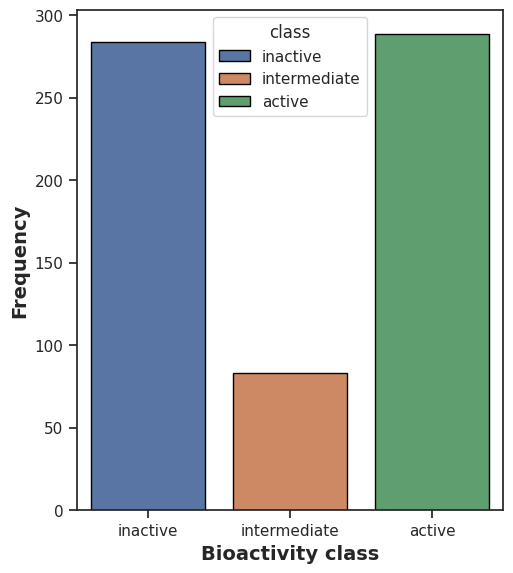

In [25]:
plt.figure(figsize=(5.5, 6.5))

sns.countplot(x='class', data=df_final, edgecolor='black', hue = 'class')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

#plt.savefig('pfht1_plot_bioactivity_class.pdf')

### **Scatter plot of MW versus LogP**

It can be seen that the 2 bioactivity classes are spanning similar chemical spaces as evident by the scatter plot of MW vs LogP.

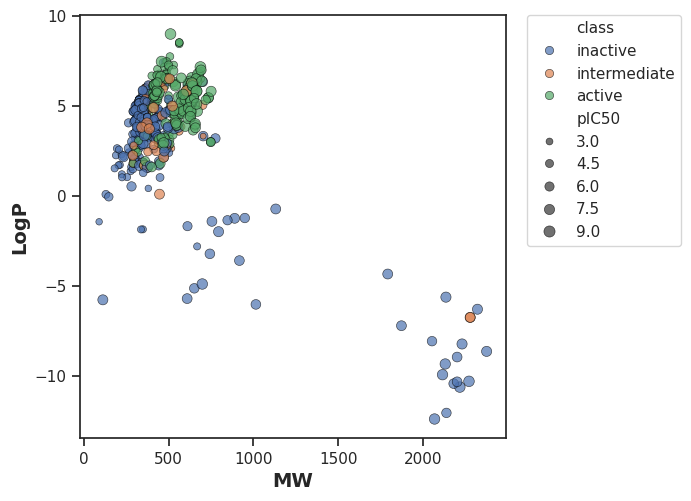

In [26]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_final, hue='class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
#plt.savefig('plot_MW_vs_LogP.pdf')

In [27]:
df_final

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL1232960,O=C(O)c1conc1O,inactive,129.071,0.0784,2.0,4.0,4.267606
1,CHEMBL1232973,O=C(O)c1nsnc1O,inactive,146.127,-0.0581,2.0,5.0,5.000000
4,CHEMBL126519,CCCc1c(O)c(O)c(C(=O)O)c2cc(Cc3ccccc3)c(C)cc12,inactive,188.182,2.2436,2.0,2.0,3.301030
5,CHEMBL1688790,O=C(O)c1cc2c(C(F)(F)F)cc(-c3ccccc3)cc2n1O,inactive,347.224,-1.8630,5.0,10.0,3.301030
6,CHEMBL229299,O=C(O)c1ccc2ccccc2c1O,inactive,336.237,-1.8690,5.0,7.0,3.301030
...,...,...,...,...,...,...,...,...
651,NaN,NaN,active,660.121,8.2284,4.0,7.0,NaN
652,NaN,NaN,active,629.088,8.2695,3.0,7.0,NaN
653,NaN,NaN,active,680.136,8.8177,3.0,8.0,NaN
654,NaN,NaN,active,603.119,6.7797,3.0,7.0,NaN


In [28]:
#remove NaN
df_cleaned = df_final.dropna()

df_cleaned

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL1232960,O=C(O)c1conc1O,inactive,129.071,0.0784,2.0,4.0,4.267606
1,CHEMBL1232973,O=C(O)c1nsnc1O,inactive,146.127,-0.0581,2.0,5.0,5.000000
4,CHEMBL126519,CCCc1c(O)c(O)c(C(=O)O)c2cc(Cc3ccccc3)c(C)cc12,inactive,188.182,2.2436,2.0,2.0,3.301030
5,CHEMBL1688790,O=C(O)c1cc2c(C(F)(F)F)cc(-c3ccccc3)cc2n1O,inactive,347.224,-1.8630,5.0,10.0,3.301030
6,CHEMBL229299,O=C(O)c1ccc2ccccc2c1O,inactive,336.237,-1.8690,5.0,7.0,3.301030
...,...,...,...,...,...,...,...,...
633,CHEMBL4740759,CC(C)(C#Cc1cccc(-c2nn(-c3nc(C(=O)O)cs3)c(CCC3C...,active,420.964,6.2154,1.0,6.0,5.342944
634,CHEMBL4786289,CC1(CC#Cc2cccc(-c3nn(-c4nc(C(=O)O)cs4)c(CCC4CC...,active,424.905,5.7980,2.0,5.0,6.512862
635,CHEMBL4758312,NS(=O)(=O)c1ccc(Cc2c(-c3cccc(C#CC4CC45CC5)c3)n...,active,430.934,5.8595,2.0,6.0,6.913640
636,CHEMBL4759279,NS(=O)(=O)c1ccc(Cc2c(-c3cccc(C#CC4CC4C4CC4)c3)...,active,432.925,6.2930,1.0,5.0,5.930332


In [29]:
#subset the pIC50
pIC = df_final[("pIC50")]

In [30]:
# There might be one or more valid SMILES that can represent one compound
# Thanks to Pat Walters for this information,checkout his excellent blog: https://www.blogger.com/profile/18223198920629617711
def canonical_smiles(smiles):
    mols = [Chem.MolFromSmiles(smi) for smi in smiles]
    smiles = [Chem.MolToSmiles(mol) for mol in mols]
    return smiles

## Calculate descriptors using RDkit

### a. General molecular descriptors-about 200 molecular descriptors

In [31]:
def RDkit_descriptors(smiles):
    mols = [Chem.MolFromSmiles(i) for i in smiles]
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()

    Mol_descriptors =[]
    for mol in mols:
        # add hydrogens to molecules
        mol=Chem.AddHs(mol)
        # Calculate all 200 descriptors for each molecule
        descriptors = calc.CalcDescriptors(mol)
        Mol_descriptors.append(descriptors)
    return Mol_descriptors,desc_names

In [32]:
# Function call
Mol_descriptors,desc_names = RDkit_descriptors(df_cleaned["canonical_smiles"])

In [33]:
df_with_200_descriptors = pd.DataFrame(Mol_descriptors,columns=desc_names)
df_with_200_descriptors

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,10.682037,-1.149537,10.682037,0.472222,0.560420,129.071,126.047,129.006208,48,0,...,0,0,0,0,0,0,0,0,0,0
1,10.585370,-0.985185,10.585370,0.243287,0.579534,146.127,144.111,145.978613,48,0,...,0,0,0,0,0,0,0,0,0,0
2,12.976272,-4.021521,12.976272,0.983868,0.577619,350.414,328.238,350.151809,134,0,...,0,0,0,0,0,0,0,0,0,0
3,14.025244,-5.391600,14.025244,0.004328,0.693199,321.254,311.174,321.061278,118,0,...,0,0,0,0,0,0,0,0,0,0
4,11.589584,-1.365684,11.589584,0.347425,0.721069,188.182,180.118,188.047344,70,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520,16.383284,-5.841336,16.383284,0.117052,0.200442,632.783,599.519,632.192726,228,0,...,0,1,0,0,0,1,0,0,0,0
521,16.316842,-5.806705,16.316842,0.082174,0.211345,618.756,587.508,618.177076,222,0,...,0,1,0,0,0,1,0,0,0,0
522,16.297485,-5.778250,16.297485,0.037959,0.236946,616.740,587.508,616.161426,220,0,...,0,1,0,0,0,1,0,0,0,0
523,16.339919,-5.803229,16.339919,0.067040,0.212942,630.767,599.519,630.177076,226,0,...,0,1,0,0,0,1,0,0,0,0


In [34]:
fp_pIC = pd.concat([df_with_200_descriptors, df_lipinski, pIC], axis=1)

In [35]:
fp_pIC.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,10.682037,-1.149537,10.682037,0.472222,0.560420,129.071,126.047,129.006208,48.0,0.0,...,0.0,0.0,0.0,0.0,0.0,129.071,0.07840,2.0,4.0,4.267606
1,10.585370,-0.985185,10.585370,0.243287,0.579534,146.127,144.111,145.978613,48.0,0.0,...,0.0,0.0,0.0,0.0,0.0,146.127,-0.05810,2.0,5.0,5.000000
2,12.976272,-4.021521,12.976272,0.983868,0.577619,350.414,328.238,350.151809,134.0,0.0,...,0.0,0.0,0.0,0.0,0.0,350.414,4.80092,3.0,3.0,NaN
3,14.025244,-5.391600,14.025244,0.004328,0.693199,321.254,311.174,321.061278,118.0,0.0,...,0.0,0.0,0.0,0.0,0.0,321.254,4.26260,2.0,3.0,NaN
4,11.589584,-1.365684,11.589584,0.347425,0.721069,188.182,180.118,188.047344,70.0,0.0,...,0.0,0.0,0.0,0.0,0.0,188.182,2.24360,2.0,2.0,3.301030


In [36]:
# the Molecular is now in duplicate, one from Lipinski df (MW) and the other from the molecular descriptor (MolWt), you can drop one
fp_pIC = fp_pIC.drop('MW', axis=1)

In [37]:
fp_pIC

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,LogP,NumHDonors,NumHAcceptors,pIC50
0,10.682037,-1.149537,10.682037,0.472222,0.560420,129.071,126.047,129.006208,48.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.07840,2.0,4.0,4.267606
1,10.585370,-0.985185,10.585370,0.243287,0.579534,146.127,144.111,145.978613,48.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.05810,2.0,5.0,5.000000
2,12.976272,-4.021521,12.976272,0.983868,0.577619,350.414,328.238,350.151809,134.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.80092,3.0,3.0,NaN
3,14.025244,-5.391600,14.025244,0.004328,0.693199,321.254,311.174,321.061278,118.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.26260,2.0,3.0,NaN
4,11.589584,-1.365684,11.589584,0.347425,0.721069,188.182,180.118,188.047344,70.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.24360,2.0,2.0,3.301030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1097,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.065502
1099,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.602060
1101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.420216
1103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.602060


#Features Engineering

In [38]:
df_features = df_cleaned[['canonical_smiles', 'molecule_chembl_id']]
df_features.to_csv('features.smi', sep='\t', index= False, header=False)

In [39]:
! unzip padel.zip
! bash padel.sh

Archive:  padel.zip
   creating: PaDEL-Descriptor/
  inflating: __MACOSX/._PaDEL-Descriptor  
  inflating: PaDEL-Descriptor/MACCSFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._MACCSFingerprinter.xml  
  inflating: PaDEL-Descriptor/AtomPairs2DFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._AtomPairs2DFingerprinter.xml  
  inflating: PaDEL-Descriptor/EStateFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._EStateFingerprinter.xml  
  inflating: PaDEL-Descriptor/Fingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._Fingerprinter.xml  
  inflating: PaDEL-Descriptor/.DS_Store  
  inflating: __MACOSX/PaDEL-Descriptor/._.DS_Store  
   creating: PaDEL-Descriptor/license/
  inflating: __MACOSX/PaDEL-Descriptor/._license  
  inflating: PaDEL-Descriptor/KlekotaRothFingerprintCount.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._KlekotaRothFingerprintCount.xml  
  inflating: PaDEL-Descriptor/config  
  inflating: __MACOSX/PaDEL-Descriptor/._config  
  inf

# pereparing x and Y data matrics

In [40]:
df_model = pd.read_csv('descriptors_output.csv')
df_x = df_model.iloc[:, 1:]
molecule_names = df_model['Name']
df_x

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
521,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
522,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
523,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [41]:
df_y = df_cleaned['pIC50']
df_y

,pIC50
0,4.267606
1,5.000000
4,3.301030
5,3.301030
6,3.301030
...,...
633,5.342944
634,6.512862
635,6.913640
636,5.930332


# Remove low variance features

In [42]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
selection = VarianceThreshold(threshold=(0.8*(1-0.8)))
df_x = selection.fit_transform(df_x)
df_x.shape

(525, 195)

# Splitting Dataset

In [43]:
x_train, x_test, y_train, y_test, names_train, names_test = train_test_split(
    df_x, df_y, molecule_names, test_size=0.2
)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(names_train.shape, names_test.shape)

(420, 195) (420,)
(105, 195) (105,)
(420,) (105,)


# Random Forest

In [44]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_log_error, median_absolute_error, root_mean_squared_error
np.random.seed(42)

model = RandomForestRegressor(n_estimators=100)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)  # Root Mean Squared Error
rmsle = root_mean_squared_log_error(y_test, y_pred)  # Root Mean Squared Log Error
medae = median_absolute_error(y_test, y_pred)

print(f"R-squared (R2): {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Root Mean Squared Log Error (RMSLE): {rmsle:.4f}")
print(f"Median Absolute Error (MedAE): {medae:.4f}")


R-squared (R2): 0.5667
Mean Squared Error (MSE): 0.9643
Mean Absolute Error (MAE): 0.6647
Root Mean Squared Error (RMSE): 0.9820
Root Mean Squared Log Error (RMSLE): 0.1650
Median Absolute Error (MedAE): 0.4017


In [45]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, df_x, df_y, cv=5, scoring='r2')

print("Cross-validation R2 scores:", cv_scores)
print("Mean R2 score:", cv_scores.mean())
print("Standard deviation of R2 score:", cv_scores.std())


Cross-validation R2 scores: [-0.37707495 -1.59300146  0.22058001  0.098252   -1.11953146]
Mean R2 score: -0.5541551725288766
Standard deviation of R2 score: 0.7008650472036929


In [54]:
results = pd.DataFrame({
    'Molecule Name': names_test,
    'Predicted Value': y_pred,
    'Actual Value': y_test.values
})
results.sort_values(by='Predicted Value', ascending=False)

,Molecule Name,Predicted Value,Actual Value
464,CHEMBL4747300,8.418740,8.154902
466,CHEMBL4797357,8.315396,8.301030
462,CHEMBL4759378,8.222505,8.154902
422,CHEMBL4444963,8.139967,8.154902
483,CHEMBL4790159,7.860424,8.096910
...,...,...,...
254,CHEMBL3318538,3.988118,4.000000
383,CHEMBL4210558,3.804007,3.719649
20,CHEMBL2059004,3.483141,3.301030
19,CHEMBL2059003,3.351522,3.301030


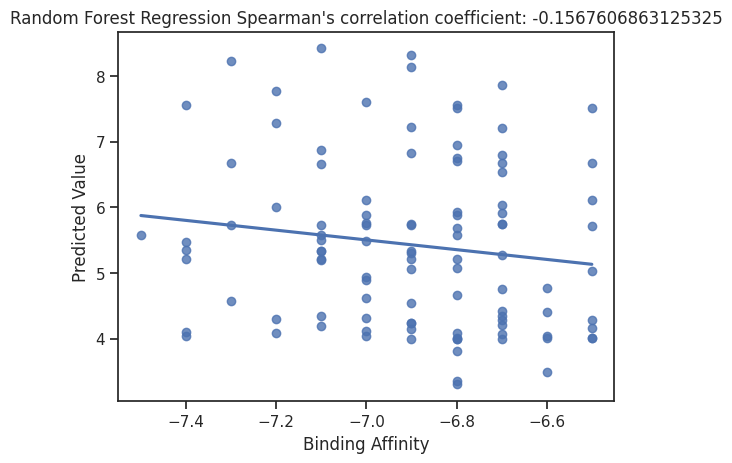

In [56]:
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

binding = pd.read_csv('LDHA_binding.csv')
binding = binding['Binding Affinity'].iloc[:105]
sns.regplot(x=binding, y=y_pred, ci=None)
correlation = spearmanr(binding, y_pred)
plt.title(f"Random Forest Regression Spearman's correlation coefficient: {correlation.correlation}")
plt.xlabel('Binding Affinity')
plt.ylabel('Predicted Value')
plt.show()